In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Translation files

Importing fastai.text

In [2]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [3]:
#!ls data/translate/

Each line contains a pair of sentences both in french and in english separated by a tabulation (TSV : Tab Separated Values)

In [4]:
!head -n 5 data/en-fr.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !


The data should be found in the file en-fr.txt in the folder data/  
data/tmp will contain temporary files

In [5]:
PATH = Path('data')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname = PATH/'en-fr.txt'

Reading the file with utf-8 encoding

In [6]:
lines = list(open(fname, encoding='utf-8'))
lines = lines[:50] # the first 50 pairs, comment out this line to train on the whole dataset

In [7]:
lines[:5]

['Go.\tVa !\n',
 'Run!\tCours\u202f!\n',
 'Run!\tCourez\u202f!\n',
 'Wow!\tÇa alors\u202f!\n',
 'Fire!\tAu feu !\n']

Separating english and french sentences

In [8]:
en = []
fr = []
for line in lines:
    enSentence, frSentence = line.rstrip().split('\t') # .rstrip() to remove the trailing \n in each line
    en.append(enSentence)
    fr.append(frSentence)

In [9]:
list(zip(en[:5], fr[:5]))

[('Go.', 'Va !'),
 ('Run!', 'Cours\u202f!'),
 ('Run!', 'Courez\u202f!'),
 ('Wow!', 'Ça alors\u202f!'),
 ('Fire!', 'Au feu !')]

Saving the sentences as pickle files (.pkl)

In [10]:
pickle.dump(en, (PATH/'en.pkl').open('wb'))
pickle.dump(fr, (PATH/'fr.pkl').open('wb'))

Loading the sentences, reading them from pickle files  
##### Add some logic before all the previous code, if you find the following files: {en,fr}.pkl, load them directly without doing it all over again

In [17]:
en = pickle.load((PATH/'en.pkl').open('rb'))
fr = pickle.load((PATH/'fr.pkl').open('rb'))

In [18]:
list(zip(en[:5], fr[:5])), len(lines)

([('Go.', 'Va !'),
  ('Run!', 'Cours\u202f!'),
  ('Run!', 'Courez\u202f!'),
  ('Wow!', 'Ça alors\u202f!'),
  ('Fire!', 'Au feu !')],
 50)

Tokenizing the english sentences, using fastai and spacy

In [19]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en))

In [20]:
en_tok[:5]

[['go', '.'], ['run', '!'], ['run', '!'], ['wow', '!'], ['fire', '!']]

In [21]:
#!python -m spacy download fr

Tokenizing the french sentences, using fastai and spacy

In [22]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr), 'fr')

In [23]:
fr_tok[:5]

[['va', '!'],
 ['cours', '\u202f', '!'],
 ['courez', '\u202f', '!'],
 ['ça', 'alors', '\u202f', '!'],
 ['au', 'feu', '!']]

In [24]:
en_tok[0], fr_tok[0]

(['go', '.'], ['va', '!'])

In [25]:
#np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

In [26]:
#keep = np.array([len(o)<30 for o in en_tok])

In [27]:
#en_tok = np.array(en_tok)[keep]
#fr_tok = np.array(fr_tok)[keep]

Saving the tokenized sentences as pickle files (.pkl)

In [28]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

Loading the tokenized sentences, reading them from pickle files

In [29]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

The following function will get as arguments the list of tokenized sentences and their language ID  
and returns the sentences converted to IDs, and the mappings ID -> token and token -> ID

In [30]:
def toks2ids(tok,pre):
    """
        Convert tokens to IDs
        tok is the list of tokenized sentences
        pre is the name of the language, example: 'fr', 'en', ...
    """
    freq = Counter(p for o in tok for p in o) # puts all tokens in Counter(.)
    
    # for a token, returns its index, int-to-string
    itos = [o for o,c in freq.most_common(40000)] # 40K most common tokens, returns tuples (token, frequency)
    itos.insert(0, '_bos_') # begining of sentence
    itos.insert(1, '_pad_') # padding
    itos.insert(2, '_eos_') # end of sentence
    itos.insert(3, '_unk_') # unknown
    # itos = [_bos_, _pad_, _eos_, _unk_, token1, token2, ...]
    
    # reverse mapping: string-to-int
    # returns 3 '_unk_' if the token isn't found
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    # stoi = {_bos_:0, _pad_:1, _eos_:2, _unk_:3, token1:4, token2:5, ...}
    
    # converts the tokenized sentences: replaces the token by its id using stoi
    # notice that we've appended 2 (_eos_) at the end of each sentence
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    
    # saving the ids to a .npy file
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    
    # saving the itos mapping to a .pkl file
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    
    return ids, itos, stoi

In [31]:
en_ids, en_itos, en_stoi = toks2ids(en_tok,'en')
fr_ids, fr_itos, fr_stoi = toks2ids(fr_tok,'fr')

The following function will load the mappings (saved from the previous function)  
and returns the sentences converted to IDs, and the mappings ID -> token and token -> ID

In [32]:
def load_ids(pre):
    """
        load saved IDs
        pre is the name of the language, example: 'fr', 'en', ...
    """
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids, itos, stoi

In [33]:
en_ids, en_itos, en_stoi = load_ids('en')
fr_ids, fr_itos, fr_stoi = load_ids('fr')

The following is how to use the ID -> token mapping to reconstruct the original tokenized sentence

In [34]:
[fr_itos[o] for o in fr_ids[0]], len(fr_itos)

(['va', '!', '_eos_'], 79)

In [35]:
[en_itos[o] for o in en_ids[0]], len(en_itos)

(['go', '.', '_eos_'], 42)

In [36]:
en_ids[:5]

array([list([7, 4, 2]), list([16, 5, 2]), list([16, 5, 2]), list([28, 5, 2]), list([29, 5, 2])], dtype=object)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

In [37]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [38]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [39]:
!ls data/

embeddings  en.pkl	fr.pkl	    models  wiki.en.pkl
en-fr.txt   en_tok.pkl	fr_tok.pkl  tmp     wiki.fr.pkl


Loading the embeddings (word vectors), the embeddings used here are trained on the text corpus of the bible  
replace them with other embeddings (wikitext for example) to get better results

In [40]:
#en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))
en_vecs = ft.load_model(str((PATH/'embeddings/en.bin')))

In [41]:
#fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))
fr_vecs = ft.load_model(str((PATH/'embeddings/fr.bin')))

Even, if the word isn't found in the embedding Fasttext, find and returns its unique embedding vector

In [42]:
emb = en_vecs.get_word_vector('word')
emb, len(emb)

(array([-0.42811,  0.00472, -0.55592,  0.23108,  0.25022, -0.24158, -0.45753, -0.35123, -0.33665, -0.10807,
        -0.08436, -0.25136, -0.56695, -0.84764, -0.1322 ,  0.14316, -0.48988, -0.327  , -0.20238,  0.10418,
         0.64037, -0.52406,  0.37063,  0.08053, -0.22075, -0.3133 , -0.16693,  0.27541, -0.83423,  0.72061,
         0.26193, -0.26927,  0.33067, -0.29437, -0.18973,  0.24391,  0.21215, -0.18755,  0.08848, -0.49965,
         0.66024,  0.34113,  0.05566, -0.03431, -0.08241,  0.18887,  0.10322,  0.30522,  1.01105,  0.70856,
        -0.02141, -0.09663, -0.51842,  0.40998,  0.36047,  0.09259,  0.12745,  0.1713 ,  0.67702,  0.51115,
         0.59954,  0.11556,  0.1054 , -0.3921 , -0.13521,  0.14449, -0.54714, -0.13172, -0.06877,  0.21863,
        -0.00522,  0.24992, -0.22379, -0.1001 ,  0.02345,  0.55127,  0.0052 , -0.47208,  0.02044, -0.11235,
        -0.61071,  0.62704, -0.20642, -0.0206 ,  0.05281, -0.07086, -0.25795, -0.68857,  0.2554 , -0.37531,
        -0.41069,  0.25751, 

In [43]:
emb = fr_vecs.get_word_vector('mot')
emb, len(emb)

(array([-0.07974,  0.08461,  0.35847,  0.18693,  0.0896 ,  0.41236,  0.03115,  0.32625,  0.28907,  0.14129,
        -0.33977, -0.14277,  0.09088,  0.03029, -0.27774,  0.04753, -0.09452,  0.27132, -0.22255,  0.38899,
        -0.35074, -0.20456, -0.2683 ,  0.32908,  0.01609, -0.23642, -0.14939,  0.16693,  0.00914, -0.2081 ,
         0.52242, -0.14854,  0.08188,  0.51043, -0.37571, -0.14249, -0.16533, -0.23474,  0.20654, -0.31629,
        -0.1563 , -0.19745, -0.48685,  0.28842, -0.22111, -0.12055, -0.10207,  0.16942,  0.41112,  0.10763,
        -0.00341,  0.6312 , -0.06367, -0.29418, -0.09617, -0.12286,  0.02321,  0.5479 ,  0.12541,  0.66944,
        -0.04868,  0.71005,  0.36709, -0.00205,  0.29375,  0.15777,  0.08099,  0.0686 ,  0.15842,  0.1739 ,
        -0.32733,  0.24166, -0.19596,  0.30417, -0.26513, -0.22868, -0.31623, -0.30047, -0.15973, -0.61035,
         0.49594, -0.15864,  0.234  ,  0.58409,  0.22567,  0.04142, -0.24763,  0.18914, -0.05537, -0.62398,
         0.30289, -0.13245, 

A better way than using the following function is to use fr_vecs and en_vecs directly  
Using a dictionary will trigger a KeyError if we want to get the embedding vector of a word which is not found

In [44]:
#def get_vecs(lang, ft_vecs):
#    """
#        Creates a dictionary of {word: word vector} from the fasttext object ft_vecs
#        and saving it into a pickle file .pkl
#    """
#    # we can get an error if we want to get the word vector of a word which isn't in this dictionary !
#    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
#    
#    # saving the vector in a .pkl file
#    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
#    return vecd

In [45]:
#en_vecd = get_vecs('en', en_vecs)
#fr_vecd = get_vecs('fr', fr_vecs)

In [46]:
#en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
#fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [47]:
#ft_vecs = en_vecs
#ft_words = ft_vecs.get_words(include_freq=True)
#ft_words[0][:5], ft_words[1][:5]

In [48]:
#ft_word_dict = {k:v for k,v in zip(*ft_words)}
#ft_word_dict

In [49]:
#ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])
#ft_words

In [50]:
#len(ft_words)

Using the following functions is a better idea

In [51]:
def getFrWordVector(word):
    return fr_vecs.get_word_vector(word)

In [52]:
def getEnWordVector(word):
    return en_vecs.get_word_vector(word)

In [53]:
dim_en_vec = len(getEnWordVector(','))
dim_fr_vec = len(getFrWordVector(','))
dim_en_vec, dim_fr_vec

(100, 100)

In [54]:
#dim_en_vec = len(en_vecd[','] if ',' in en_vecd.keys() else en_vecs.get_word_vector(','))
#dim_fr_vec = len(fr_vecd[','] if ',' in fr_vecd.keys() else fr_vecs.get_word_vector(','))
#dim_en_vec, dim_fr_vec

In [55]:
#en_vecs_np = np.stack(list(en_vecd.values()))
#en_vecs_np.mean(), en_vecs_np.std()

We need to know the mean and the variance of our word vectors  
we can use the following function to do that

In [56]:
def getStatistics(fasttextVectors):
    vecd = {w:fasttextVectors.get_word_vector(w) for w in fasttextVectors.get_words()}
    vecs_np = np.stack(list(vecd.values()))
    return vecs_np.mean(), vecs_np.std()

In [57]:
getStatistics(fr_vecs) # (0.027238548, 0.30283847)

(0.027238548, 0.30283847)

In [58]:
getStatistics(en_vecs) # (0.018482028, 0.27999485)

(0.018482028, 0.27999485)

Both sets of vectors have rughly the same statistics, about 0 mean and 0.3 standard deviation.  
If we multiply the vectors by 0.3, we'll get a new set of vectors (normalized) with mean = 0 and standard deviation = 1

## Model data

Truncating the data isn't a good idea at all ! we shouldn't alter the data, we have to use as it is !

In [59]:
#enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
#frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
#enlen_90, frlen_90

In [60]:
#en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
#fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])
#en_ids_tr[:5]

The following class is a generic PyTorch dataset, used to prepare the data to be used by PyTorch and fastai

In [61]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

Train-Test split: 90% training / 10% testing

In [62]:
# train-test split
#np.random.seed(42)
trn_keep = np.random.rand(len(en_ids)) > 0.1
en_trn, fr_trn = en_ids[trn_keep], fr_ids[trn_keep]
en_val, fr_val = en_ids[~trn_keep], fr_ids[~trn_keep]
len(en_trn),len(en_val)

(45, 5)

Creating the datasets

In [63]:
trn_ds = Seq2SeqDataset(fr_trn, en_trn)
val_ds = Seq2SeqDataset(fr_val, en_val)

Setting the batch size

In [64]:
#bs=125 # batch size
bs=10 # batch size

**SortishSampler** : Returns an iterator that traverses the data in randomly ordered batches that are approximately the same size. (used for training set)  
**SortSampler** : Returns a sorted iterator (used for testing set)  

In [65]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [66]:
??ModelData

**Classifier** → padding in the beginning. Because we want that final token to represent the last word of the movie review.  
**Decoder** → padding at the end. As you will see, it actually is going to work out a bit better to have the padding at the end.

In [67]:
??DataLoader

In [68]:
# we don't have any data augmentation tasks, so we can set num_workers to 1
# we have to transpose the tensors (why ?!!!)
# we use 1 (_pad_) to pad the shortest tensor, so that all the tensors would have the same length
#     a tensor must be rectangular
# we want our padding to be at the end, not at the start, that's why pre_pad is set to False
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)

# why int(bs*1.6) ?!!!
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)

# PATH is used to save temporary files, models, ...
md = ModelData(PATH, trn_dl, val_dl)

In [69]:
trn_ds[0]

[array([12,  4,  2]), array([7, 4, 2])]

In [70]:
it = iter(trn_dl)

#for i in it:
#    print(i)

#print(next(it))

"""
The (1)s are the padding characters _pad_
The (2)s at the end are the end-of-sentence tokens _eos_
[
   45     7    61    46    10   123   125    62    13    20
    8    42     5     4    26     8     4     5    28    56
   16     4     2     2     5    16     2     2     5     6
    4     2    (1)   (1)    2     4    (1)   (1)    2     4
    2    (1)   (1)   (1)   (1)    2    (1)   (1)   (1)    2
[torch.LongTensor of size 5x10]
, 
   23     6    11    10     6    23    10    11     7    24
   22    17    12    16    56    22    12    12    31     5
    4     4     4     4     4     4     4     4     4     2
    2     2     2     2     2     2     2     2     2    (1)
[torch.LongTensor of size 4x10]
]
"""

its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(7, 4), (6, 4), (5, 3), (8, 5), (4, 3)]

## Initial model

In [71]:
?nn.Embedding

The word vectors have a mean around 0 and a variance around 3, that's why we multiplied the vector by 3  
The general rule is : word_vector x variance + mean

In [72]:
#def create_emb(vecs, itos, em_sz):
#    emb = nn.Embedding(len(itos), em_sz, padding_idx=1) # 1: _pad_, dimension: (vocab size x embedding size)
#    wgts = emb.weight.data
#    miss = []
#    for i,w in enumerate(itos):
#        try: wgts[i] = torch.from_numpy(vecs[w]*3)
#        except: miss.append(w)
#    print(len(miss),miss[5:10])
#    return emb

To make a vector standard normal (have a mean of 0 and a standard deviation of 1)  

$$Y = \frac{X-\mu}{\sigma}$$  

$\mu$ is the mean of X, $\sigma$ is its standard deviation.  
We can create a function to do just that ;)

In [77]:
def normalize(vector, mean, standardDeviation):
    """
        This function returns the 'normalized' version of vector
        by subtracting the mean than dividing by the standard deviation
        Hepler function to be used in the function `create_emb`
    """
    return (vector - mean) / standardDeviation

This version uses the fasttext object firectly so no mises ! even if the word doesn't exist in the original embeddings, fasttext will generate its unique embedding vector. I don't want to miss any word ! whatever was its frequency !

In [78]:
def create_emb(fasttextVectors, itos, em_sz, mean=0, standardDeviation=1): # standardDeviation is 0.3 in our example
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1) # 1: _pad_, dimension: (vocab size x embedding size)
    wgts = emb.weight.data
    #miss = []
    for i,w in enumerate(itos):
        #assert len(fasttextVectors.get_word_vector(w)) == em_sz
        #wgts[i] = torch.from_numpy(fasttextVectors.get_word_vector(w)*standardDeviation)
        wgts[i] = torch.from_numpy(normalize(fasttextVectors.get_word_vector(w), mean, standardDeviation))
        #try: wgts[i] = torch.from_numpy(fasttextVectors.get_word_vector(w)*standardDeviation)
        #except: miss.append(w)
    #print(len(miss))
    return emb

In [79]:
create_emb(en_vecs, en_itos, 100, 0.3)

Embedding(42, 100, padding_idx=1)

In [75]:
nh, nl = 256, 2

xxx_enc are encoder's variables, xxx_dec are decoder's variables  
out_xxx is what's going to be at the output of the encoder / decoder

the GRU computations  
$$
        \begin{array}{ll}
        r_t = \mathrm{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \mathrm{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)} \\
        \end{array}
$$

In [80]:
?nn.GRU

In [82]:
?torch.stack

In [84]:
# Returns a new tensor with a dimension of size one inserted at the specified position.
?torch.unsqueeze

In [59]:
class Seq2SeqRNN(nn.Module):
    """
    * The embedding layers are used to get the fasttext embedding vector from the token's index in the vocabulary
    (we can also fine tune the embeddings, they will become learnable parameters, and train them end to end)
    * emb_enc: Embeddings for the encoder
    * emb_dec: Embeddings for the decoder
    * we can use LSTMs instead of GRUs
    * The embedding size of pretrained fasttext vectors is 300
    * The embeddings can be learnable: they have the attribute weight which is a Variable containing the attribute
        data which is a Tensor
    * The embeddings are initially random, we go through our vocabulary, if we find the token, we replace the
        random vector by its corresponding fasttext embedding, the random vectors have a standard deviation of1
        but our fasttext vectors have a standard deviation of 0.3, that's why we've multiplied by 3
    """
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        
        # adding dropout prevent overfitting (add visualization of dropout ? in the presentation and report)
        # analogy: died neurons in the brain !
        self.emb_enc_drop = nn.Dropout(0.15)
        
        # the RNN cell (GRU, LSTM)
        # the input to the RNN is the size of the embedding
        # nh is the number of hidden units
        # nl is the number of layers
        # 0.25 dropout inside the RNN
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        
        # transform the hidden output (RNN output) into something to be fed to the decoder
        # this is a simple transformation, so it should be a matrix multiplication without adding a bias
        # this operation is the reverse of the embedding, and the embedding doesn’t have a bias. (jeremy's answer)
        # that's why bias is set to False
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        # sl: sentence length, bs: batch size
        sl, bs = inp.size()
        h = self.initHidden(bs)
        
        # putting the input into the embedding, then through the dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        # we put the initial hidden state (zeros) and the embedding to the RNN
        # which spits out the final hidden state
        enc_out, h = self.gru_enc(emb, h)
        
        # the final hidden state is passing through the linear layer so that we'll
        # have something in the right size to feed to our decoder
        h = self.out_enc(h)
        
        # input ---> embedding ---> hidden vector (h, which is the same as s in the figure shown in the course)
        # the hidden vector hopefully will learn to contain all the information about what that sentence
        # says and how it says it

        # the previous translated word, first it is NULL (vector of zeros)
        # decoder input, initially zeros
        # long because the output should be the indices
        dec_inp = V(torch.zeros(bs).long())
        res = []
        
        # self.out_sl is the length of the largest english sentence, because we're translating into english
        # it can't be possibly longer than that (at least in our corpus), it we use it on longer sentences
        # this will fail, we can pass in a bigger value
        # --> why we don't change it to a while loop (while the token isn't _eos_ or _pad_ ?)
        for i in range(self.out_sl):           
            # the basic idea is the same: we put the input through the embedding
            # adding a unit axis / dimension in the specified position using .unsqueeze(0)
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            
            # then through the RNN
            outp, h = self.gru_dec(emb, h)
            
            # stick the output of the RNN through the dropout then through a linear layer
            outp = self.out(self.out_drop(outp[0]))
            
            # append the result to the results list
            res.append(outp)
            
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break

        # at the end, we're going to stack that list up into a single tensor and return it
        return torch.stack(res)
    
    # used to initialize the hidden state vector with zeros
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

Normally, a RNN works on a whole sequence at a time but we've got a for loop to go through each part of the sequence separately so we have to add a leading unit access to the start `unsqueeze(0)`

In [60]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [147]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [148]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

58 ['.', '\u202f', '?', "j'", "l'"]
26 ['!', 'i', 'won', '?', 'nice']


In [149]:
# test jupyter notebook's widgets
#from ipywidgets import IntProgress
#IntProgress(10,max=100)

 67%|██████▋   | 58/87 [00:12<00:06,  4.47it/s, loss=20.7]

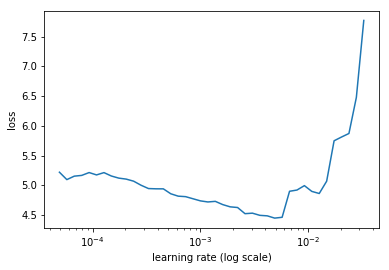

In [64]:
learn.lr_find()
learn.sched.plot()

In [150]:
lr=3e-3

We can safely ignore the error 'Set changed size during iteration'  
http://forums.fast.ai/t/runtimeerror-set-changed-size-during-iteration/7565

In [66]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

 43%|████▎     | 37/87 [00:06<00:09,  5.40it/s, loss=3.86]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      3.741226   3.32703   
    1      3.91051    2.340131                            
    2      2.957071   2.818557                            
    3      2.509991   2.066287                            
    4      2.251053   2.040451                            
    5      1.466624   1.569259                            
    6      1.270903   2.047033                            
    7      1.147333   1.515473                            
    8      0.73335    1.559318                             
    9      0.553818   1.473312                             
    10     0.372714   1.669936                             
    11     0.307888   1.40455                              



[array([1.40455])]

In [67]:
learn.save('initial')

In [151]:
learn.load('initial')

### Test

In [152]:
for x,y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

vas-y maintenant . _eos_
go now . _eos_
i help _eos_ _eos_ _eos_

pigé   ? _eos_
got it ? _eos_
i help _eos_ _eos_ _eos_

serre - moi dans tes bras !
hug me . _eos_
i help _eos_ _eos_ _eos_

je suis parti . _eos_
i left . _eos_
i help _eos_ _eos_ _eos_

en aucune manière ! _eos_
no way ! _eos_
i help _eos_ _eos_ _eos_

sois détendu ! _eos_
be cool . _eos_
i help _eos_ _eos_ _eos_

soyez équitable ! _eos_
be fair . _eos_
i help _eos_ _eos_ _eos_

soyez gentille ! _eos_
be nice . _eos_
i help _eos_ _eos_ _eos_

venez ! _eos_
come on . _eos_
i help _eos_ _eos_ _eos_

saute . _eos_
jump . _eos_
i help _eos_ _eos_ _eos_

attends ! _eos_
wait ! _eos_
i help _eos_ _eos_ _eos_

vraiment   ? _eos_
really ? _eos_
i help _eos_ _eos_ _eos_

fantastique   ! _eos_
awesome ! _eos_
i help _eos_ _eos_ _eos_



In [145]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

print(x.shape)

#for i in range(180,190):
for i in range(1):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

torch.Size([4, 1])
vas-y maintenant . _eos_
go now . _eos_
i help _eos_ _eos_ _eos_



## Bidir

In [75]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [92]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

58 ['.', '\u202f', '?', "j'", "l'"]
26 ['!', 'i', 'won', '?', 'nice']


In [93]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

 29%|██▊       | 25/87 [00:09<00:23,  2.58it/s, loss=4]   

Exception in thread Thread-45:
Traceback (most recent call last):
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/stoufa/anaconda2/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      3.437292   2.989171  
    1      3.366644   3.10476                             
    2      3.39181    2.274079                            
    3      2.656666   1.654762                            
    4      2.038905   2.214455                            
    5      1.536672   2.00998                             
    6      1.376155   2.179717                            
    7      0.931147   2.026076                             
    8      0.696549   1.444683                             
    9      0.646661   2.439948                             
    10     0.33823    1.990603                             
    11     0.327684   1.757529                             



[array([1.75753])]

In [94]:
learn.save('bidir')

### Test - Bidir

In [95]:
learn.load('bidir')
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

print(x.shape)

#for i in range(180,190):
for i in range(1):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

torch.Size([4, 1])
vas-y maintenant . _eos_
go now . _eos_
go now . _eos_ _eos_



## Teacher forcing

In [96]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [97]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [98]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

58 ['.', '\u202f', '?', "j'", "l'"]
26 ['!', 'i', 'won', '?', 'nice']


In [99]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                            
    0      2.817046   3.009763  
    1      2.616116   4.335323                            
    2      2.076136   2.87762                             
    3      1.699857   2.722105                            
    4      1.51282    1.857763                            
    5      1.319323   1.642739                            
    6      1.095293   2.070943                             
    7      0.966708   2.353443                             
    8      0.750304   1.516278                             
    9      0.607719   1.662743                             
    10     0.403238   1.764716                             
    11     0.224393   1.923597                             



[array([1.9236])]

In [100]:
learn.save('forcing')

## Attentional model

In [101]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [102]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [103]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

58 ['.', '\u202f', '?', "j'", "l'"]
26 ['!', 'i', 'won', '?', 'nice']


In [127]:
#lr=2e-3
lr=5e-2

In [128]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                             
    0      18.29886   20.433093 
    1      55.2444    48.008169                           
    2      83.057562  152.885664                          
    3      61.409234  33.964173                           
    4      39.819258  22.943082                           
    5      37.192839  28.059798                           
    6      43.463258  70.673356                           
    7      43.285342  23.680404                           
    8      27.678315  22.930672                           
    9      21.993609  23.663328                           
    10     18.288758  20.058433                           
    11     16.890823  17.975592                           
    12     14.429924  14.699815                           
    13     11.687962  11.828473                           
    14     10.4448    11.72763                            



[array([11.72763])]

In [129]:
learn.save('attn')

In [130]:
learn.load('attn')

### Test

In [131]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [132]:
x.shape[1]

1

In [133]:
for x,y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

vas-y maintenant . _eos_
go now . _eos_
us us us us us

pigé   ? _eos_
got it ? _eos_
us us us us us

serre - moi dans tes bras !
hug me . _eos_
us us us us us

je suis parti . _eos_
i left . _eos_
us us us us us

en aucune manière ! _eos_
no way ! _eos_
us us us us us

sois détendu ! _eos_
be cool . _eos_
us us us us us

soyez équitable ! _eos_
be fair . _eos_
us us us us us

soyez gentille ! _eos_
be nice . _eos_
us us us us us

venez ! _eos_
come on . _eos_
us us us us us

saute . _eos_
jump . _eos_
us us us us us

attends ! _eos_
wait ! _eos_
us us us us us

vraiment   ? _eos_
really ? _eos_
us us us us us

fantastique   ! _eos_
awesome ! _eos_
us us us us us



In [134]:
#for i in range(180,190):
for i in range(x.shape[1]):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

fantastique   ! _eos_
awesome ! _eos_
us us us us us



In [136]:
#attn = to_np(attns[...,180])
attn = to_np(attns)

IndexError: index 5 is out of bounds for axis 0 with size 5

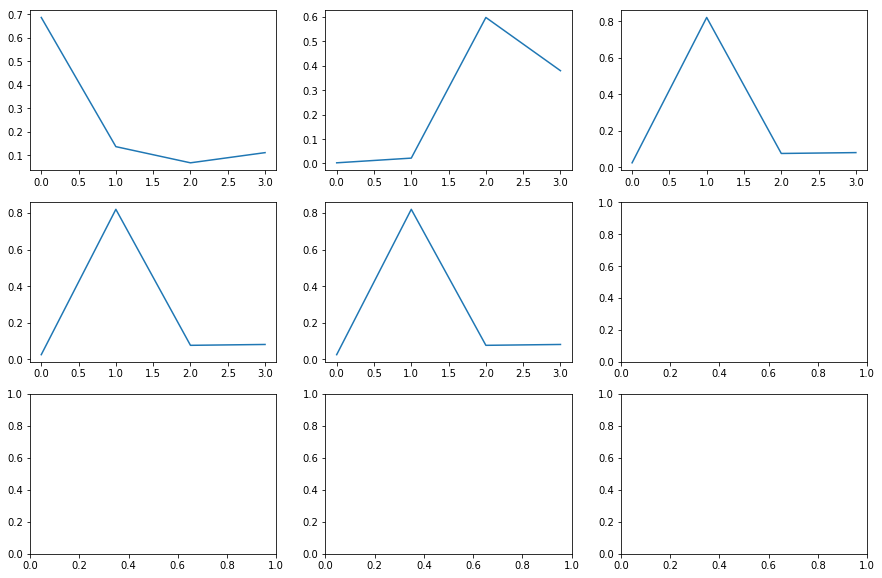

In [137]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

## All

In [138]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [139]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

58 ['.', '\u202f', '?', "j'", "l'"]
26 ['!', 'i', 'won', '?', 'nice']


In [140]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                            
    0      22.50451   19.135098 
    1      167.396686 52.193733                           
    2      213.272696 175.169619                         
    3      151.853019 113.348848                         
    4      104.302165 63.093213                          
    5      74.818993  46.885777                           
    6      60.612482  33.421799                           
    7      47.694162  58.685906                           
    8      41.594945  32.12168                            
    9      36.003564  45.317002                           
    10     32.072617  39.232833                           
    11     27.169067  31.440382                           
    12     21.159663  27.880654                           
    13     22.157123  39.520714                           
    14     20.78603   25.013472                           



[array([25.01347])]

In [141]:
for x,y in iter(val_dl):
    #print(x)
    for i in range(x.shape[1]):
        print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
        print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
        print()

vas-y maintenant . _eos_
go now . _eos_
us us us us us

pigé   ? _eos_
got it ? _eos_
us us us us us

serre - moi dans tes bras !
hug me . _eos_
us us us us us

je suis parti . _eos_
i left . _eos_
us us us us us

en aucune manière ! _eos_
no way ! _eos_
us us us us us

sois détendu ! _eos_
be cool . _eos_
us us us us us

soyez équitable ! _eos_
be fair . _eos_
us us us us us

soyez gentille ! _eos_
be nice . _eos_
us us us us us

venez ! _eos_
come on . _eos_
us us us us us

saute . _eos_
jump . _eos_
us us us us us

attends ! _eos_
wait ! _eos_
us us us us us

vraiment   ? _eos_
really ? _eos_
us us us us us

fantastique   ! _eos_
awesome ! _eos_
us us us us us



### Test

In [143]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

#for i in range(180,190):
for i in range(1):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

vas-y maintenant . _eos_
go now . _eos_
no _eos_ _eos_ _eos_ _eos_

